In [1]:
cwk_dir ="drive/MyDrive/NLU Coursework/" #For running in Jack's Google Drive

# Setup

## Connect Google Drive Folder

In [2]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


## Imports

In [3]:
from tensorflow.keras import utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Add, Layer, LSTM, Bidirectional, Embedding, concatenate, BatchNormalization, SimpleRNN, Attention, GlobalMaxPooling1D, GlobalAveragePooling1D, Conv1D, MaxPooling1D, TimeDistributed
from tensorflow.keras.optimizers.legacy import SGD, Adam, RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.metrics import SparseCategoricalAccuracy as Acc
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy as KAcc
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2

import keras

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import typing
from PIL import Image
import json
from nltk.corpus import stopwords
import gensim.downloader as api
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
import string
from random import randint

In [5]:
from transformers import BertTokenizer, BertModel

In [6]:
#Imports from local libraries
sys.path.append(cwk_dir)
from classes.evaluation import evaluate
from classes.preprocessing import load_data

## Primary Variables

Filepath variables

In [7]:
solution_dir = os.path.join(cwk_dir, "solution_B")
models_dir = os.path.join(solution_dir, "models")
results_dir = os.path.join(solution_dir, "results")

Preprocessing variables

In [20]:
LOWER: bool = True
PADDING: str = "post"

nltk.download('stopwords')
# STOP_WORDS = set(stopwords.words('english'))
STOP_WORDS = []

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training variables

In [9]:
INITIAL_LR: float = 2e-5
EPOCHS: int = 10
VALIDATION_SPLIT: float = 0.2
BATCH_SIZE: int = 256

DROPOUT: float = 0.25

OPTIMIZER = RMSprop(INITIAL_LR)

Other

In [10]:
MAX_SEQ_LENGTH: int = 512 #None is the value to denote that there is no max length. Max length is recommended
VOCAB_SIZE: int = None #None is the value to denote that there is no vocab size yet. This is set later, once we have the training data
EMBEDDING_SIZE: int = None

## Functions

In [11]:
def show_model_architecture(model: Model, filename: str) -> None:
  """
  Takes a model architecture and will a diagram of the architecture. Saves this diagram also, to the filename specified
  """
  model.summary()
  filename = os.path.join(results_dir, filename)
  plot_model(model, to_file=filename)
  img = Image.open(filename)
  fig, ax = plt.subplots(figsize=(15, 15))
  plt.imshow(img, aspect='equal')

In [12]:
def tokenize_data(tokenizer: BertTokenizer, premises: typing.List[str], hypotheses: typing.List[str]) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = [tokenizer.encode(premise, add_special_tokens=True) for premise in premises]
  hypotheses = [tokenizer.encode(hypothesis, add_special_tokens=True) for hypothesis in hypotheses]

  premises = pad_sequences(premises, maxlen=MAX_SEQ_LENGTH, padding=PADDING, value=0)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_SEQ_LENGTH, padding=PADDING, value=0)

  return (np.array(premises), np.array(hypotheses))

In [13]:
def save_keras_model(model: Model, filename: str) -> None:
  """
  Saves the model that's been made
  """
  model.save_weights(os.path.join(models_dir, f"{filename}.hdf5"))
  model_architecture = model.to_json()
  with open(os.path.join(models_dir, f"{filename}.json"), "w") as f:
    f.write(json.dumps(model_architecture, indent=4))

In [14]:
def clean_sentences(sentences: typing.List[str]) -> typing.List[str]:
  """
  Takes a list of sentences & cleans them. Remove stopwords, reduces to lower case, removes punctuation
  """
  sentences = [[word.lower().translate(str.maketrans("","",string.punctuation)) for word in sentence.split(" ") if word not in STOP_WORDS] for sentence in sentences]
  sentences = np.array([" ".join(sentence) for sentence in sentences])
  return sentences


In [15]:
def plot_history(history, export_path, legend: typing.List[str] = ['train', 'test']):
  """
  Will plot the history of a model, labelling it appropriately
  """
  plt.figure(figsize=(20, 10))
  plt.subplot(1, 2, 1)

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(legend, loc='upper left')

  plt.savefig(os.path.join(results_dir, export_path))

  plt.show()


# Data Preprocessing

## Load Data

In [18]:
(train_premises, train_hypotheses, train_labels), (dev_premises, dev_hypotheses, dev_labels) = load_data(cwk_dir)

In [19]:
train_labels = np.array(train_labels).reshape(len(train_labels),1)
dev_labels = np.array(dev_labels).reshape(len(dev_labels),1)

In [21]:
#Removes stop words, reduces to lower case and will shorten to the max length
train_premises = clean_sentences(sentences=train_premises)
train_hypotheses = clean_sentences(sentences=train_hypotheses)

dev_premises = clean_sentences(sentences=dev_premises)
dev_hypotheses = clean_sentences(sentences=dev_hypotheses)

### Example

In [24]:
index = randint(0, len(train_premises))
print(f"Premise: {train_premises[index]}")
print(f"Hypothesis: {train_hypotheses[index]}")
print(f"Label: {train_labels[index]}")

Premise:  he was wrong
Hypothesis: he was definitely correct
Label: [0]


## Tokenize Data

In [25]:
model_name = 'bert-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [26]:
train_premises, train_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(train_premises), hypotheses=list(train_hypotheses))
dev_premises, dev_hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(dev_premises), hypotheses=list(dev_hypotheses))

In [27]:
if(MAX_SEQ_LENGTH is None):
  MAX_SEQ_LENGTH = max(max([len(sample) for sample in train_hypotheses]), max([len(sample) for sample in train_premises]), max([len(sample) for sample in dev_premises]), max([len(sample) for sample in dev_hypotheses]))
print(f"Max sequence length: {MAX_SEQ_LENGTH}")

Max sequence length: 512


In [29]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 30522


### Example

In [44]:
#Premise
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_premises[index])}")
print(f"Tokens: {train_premises[index][:50]}")

Sentence: ['[CLS]', 'he', 'was', 'wrong', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

In [46]:
#Hypothesis
print(f"Sentence: {tokenizer.convert_ids_to_tokens(train_hypotheses[index])}")
print(f"Tokens: {train_hypotheses[index][:50]}")

Sentence: ['[CLS]', 'he', 'was', 'definitely', 'correct', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

## Embedding Matrix

In [30]:
embedding_matrix = bert_model.embeddings.word_embeddings.weight.detach().numpy()

In [31]:
if(EMBEDDING_SIZE is None):
  EMBEDDING_SIZE = np.shape(embedding_matrix)[1]
print(f"Embedding size: {EMBEDDING_SIZE}")

Embedding size: 768


# Model Training

## Learning Rate

In [ ]:
# decay_steps = int((len(train_premises)//BATCH_SIZE) * (1-VALIDATION_SPLIT)) + 1

# lr_schedule = ExponentialDecay(
#     INITIAL_LR,
#     decay_steps=decay_steps,
#     decay_rate=0.99,
#     staircase=True)

# OPTIMIZER = Adam(learning_rate=lr_schedule)

## Model Architecture

In [ ]:
# input_premises = Input(shape=(MAX_SEQ_LENGTH,))
# input_hypotheses = Input(shape=(MAX_SEQ_LENGTH,))

# embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, input_length = MAX_SEQ_LENGTH, weights=[embedding_matrix], trainable=False)

# premises = embedding_layer(input_premises)
# hypotheses = embedding_layer(input_hypotheses)

# merged = concatenate([premises, hypotheses], axis=-1)

# x = Bidirectional(LSTM(512, return_sequences=True, dropout=DROPOUT))(merged)
# x = BatchNormalization()(x)

# x = Bidirectional(LSTM(256, return_sequences=False, dropout=DROPOUT))(x)
# x = BatchNormalization()(x)

# x = Dense(256, activation='relu')(x)
# x = Dropout(DROPOUT)(x)
# x = BatchNormalization()(x)

# x = Dense(32, activation='relu')(x)
# x = Dropout(DROPOUT)(x)
# x = BatchNormalization()(x)

# output_layer = Dense(1, activation='sigmoid')(x)

# model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
# model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

# show_model_architecture(model=model, filename="architecture_bert_embed.png")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 512, 768)             2344089   ['input_1[0][0]',             
                                                          6          'input_2[0][0]']             
                                                                                                  
 concatenate (Concatenate)   (None, 512, 1536)            0         ['embedding[0][0]',       

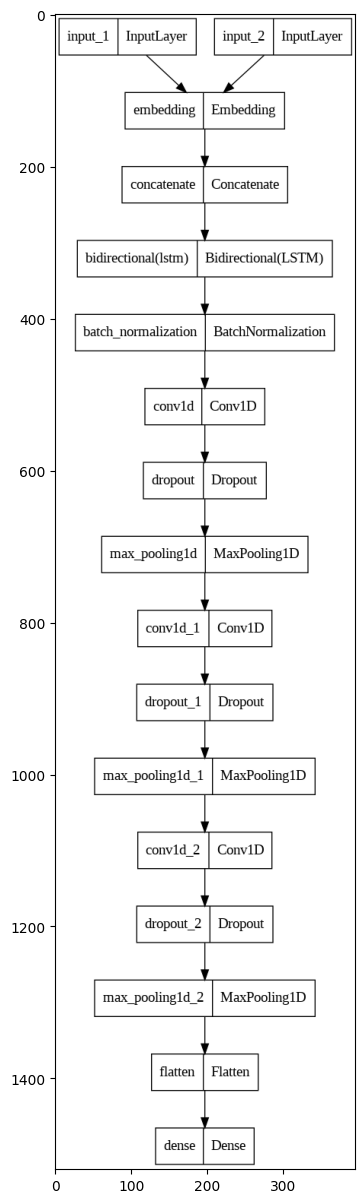

In [32]:
input_premises = Input(shape=(MAX_SEQ_LENGTH,))
input_hypotheses = Input(shape=(MAX_SEQ_LENGTH,))

embedding_layer = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_SIZE, input_length = MAX_SEQ_LENGTH, weights=[embedding_matrix], trainable=False)

premises = embedding_layer(input_premises)
hypotheses = embedding_layer(input_hypotheses)

merged = concatenate([premises, hypotheses], axis=-1)

x = Bidirectional(LSTM(512, return_sequences=True, dropout=DROPOUT))(merged)
x = BatchNormalization()(x)

x = Conv1D(256, kernel_size=3, padding='same',activation='relu')(x)
x = Dropout(DROPOUT)(x)
x = MaxPooling1D(2)(x)

x = Conv1D(128, kernel_size=3, padding='same',activation='relu')(x)
x = Dropout(DROPOUT)(x)
x = MaxPooling1D(2)(x)

x = Conv1D(64, kernel_size=3, padding='same',activation='relu')(x)
x = Dropout(DROPOUT)(x)
x = MaxPooling1D(2)(x)

x = Flatten()(x)

output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=[input_premises, input_hypotheses], outputs=output_layer)
model.compile(loss='binary_crossentropy', optimizer=OPTIMIZER, metrics=['accuracy'])

show_model_architecture(model=model, filename="architecture_bert_embed.png")

## Model Training

In [33]:
history = model.fit([train_premises, train_hypotheses], train_labels, epochs=1, batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT)

85/85 [==============================] - 85s 880ms/step - loss: 0.7024 - accuracy: 0.5301 - val_loss: 0.6926 - val_accuracy: 0.5405


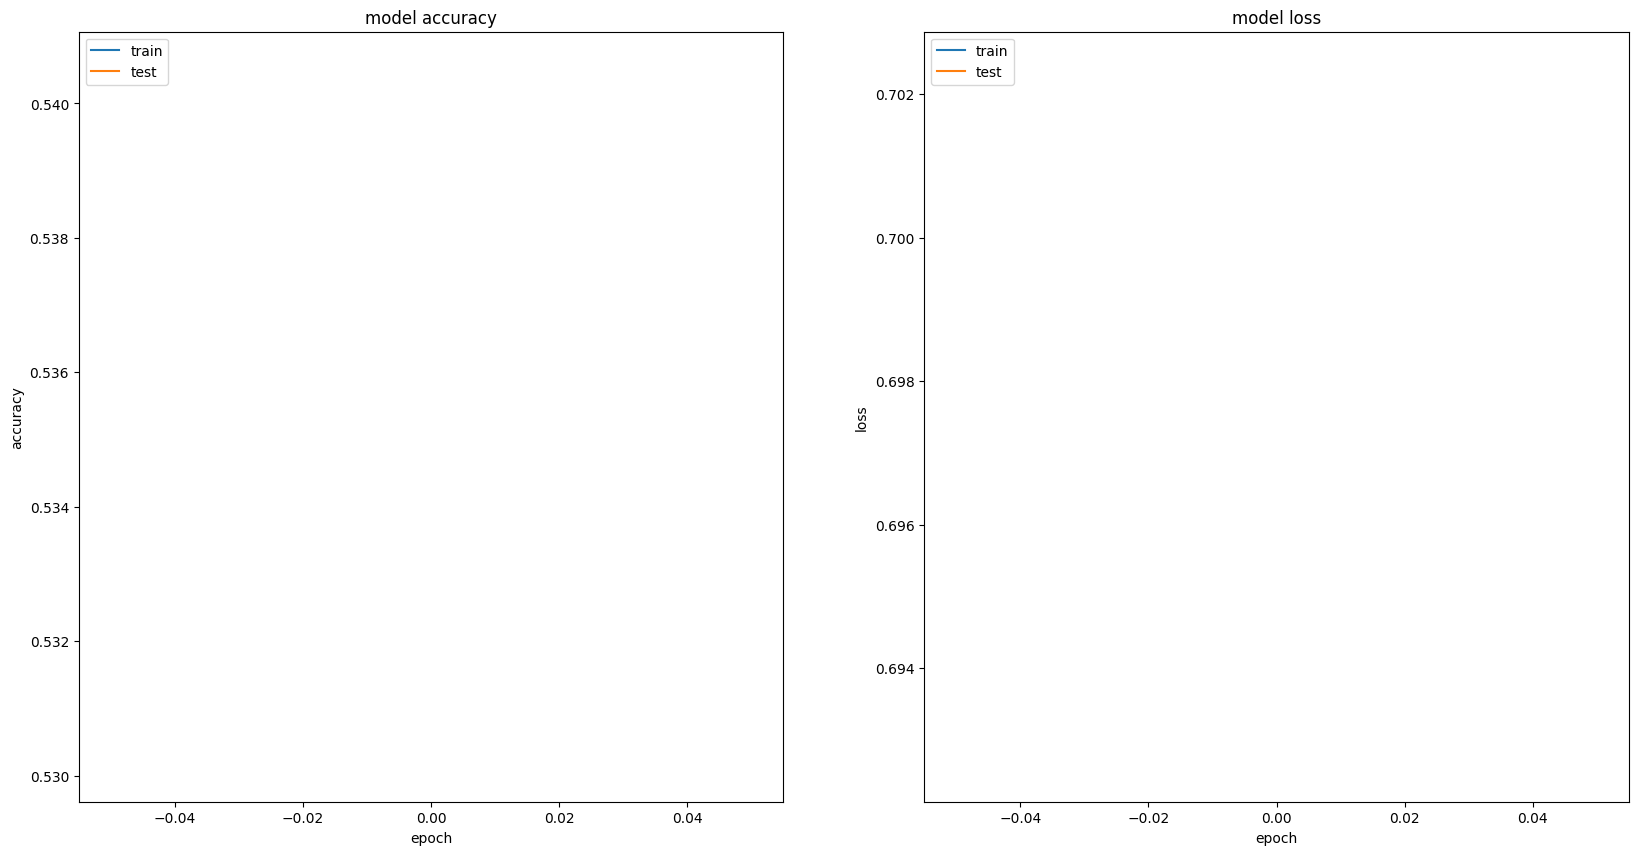

In [34]:
plot_history(history=history, export_path="model_bert_embed.pdf")

In [ ]:
#Save the model
save_keras_model(model=model, filename="model_bert_embed")

## Model Evaluation

In [ ]:
#Get loss
loss, _ = model.evaluate([dev_premises, dev_hypotheses], dev_labels)
print("\nTest score/loss:", loss)

In [43]:
predicted_labels = model.predict(x=[dev_premises, dev_hypotheses])
predicted_labels = (predicted_labels > 0.5).astype(int)

#Evaluation Metrics
test_metrics = evaluate(true_labels=np.array(dev_labels), predicted_labels=np.array(predicted_labels))
test_metrics.to_csv(os.path.join(results_dir, "metrics.csv"), index=False)
test_metrics.head()

211/211 [==============================] - 13s 60ms/step - loss: 0.6927 - accuracy: 0.5448

Test score/loss: 0.6926633715629578


,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC
0,0.544753,0.706533,0.611626,0.614711,0.202128,0.556265,0.544753,0.31433,0.486795,0.481189,0.158501
